#Faiyaz Bin Zaman
##Epoch one ID: E1-24241281-MHNUMM6G

# Loan Default Analysis
## Data Processing and Feature Engineering

We are going to take the raw dataset and prep it for our machine learning pipeline. The goal is to clean up potential issues like missing values or duplicates, and then engineer some useful features that will help the model predict loan defaults more accurately.

We'll cover the full preprocessing workflow:
1.  **Cleaning**: Handling nulls, removing duplicates, and dropping useless columns.
2.  **Feature Engineering**: improved predictive signals.
3.  **Auditing**: Checking for ethical bias.
4.  **Preprocessing**: Encoding and scaling for the final model.

In [9]:
!pip install -q kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
print("Downloading dataset from Kaggle")
path = kagglehub.dataset_download("nikhil1e9/loan-default")
print("Path to dataset files:",path)

csv_path = os.path.join(path, "Loan_default.csv")

try:
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded. Shape: {df.shape} (Rows, Columns)")
except FileNotFoundError:
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    if csv_files:
        df = pd.read_csv(os.path.join(path, csv_files[0]))
        print(f"Dataset loaded from {csv_files[0]}. Shape: {df.shape}")
    else:
        print(f"No CSV file found at {path}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Using Colab cache for faster access to the 'loan-default' dataset.
Path to dataset files: /kaggle/input/loan-default
Dataset loaded. Shape: (255347, 18) (Rows, Columns)


In [10]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# file_path = 'Loan_default.csv'
# try:
#     df = pd.read_csv(file_path)
#     print(f"Dataset loaded. Shape: {df.shape} (Rows, Columns)")
# except FileNotFoundError:
#     print(f"File not found at {file_path}")

### Step 1: Handling Missing Values

Identifying and fixing missing data. Null values will throw errors in most models, so we need to fill them in.

**Strategy:**
*   **Numerical Cols**: Using the **Median**. It's safer than the mean because it isn't skewed by outliers.
*   **Categorical Cols**: Using the **Mode** (the most frequent value) to maintain the most likely category distribution.

In [11]:

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("Null Value Check Done. Remaining Nulls:", df.isnull().sum().sum())

Null Value Check Done. Remaining Nulls: 0


### Step 2: Removing Duplicates

Next, we're checking for duplicate rows. These are basically identical copies of the same data point. If we leave them in, the model generates biased results by overweighting these specific examples. We'll drop them to keep the data clean.

In [12]:
initial_rows = len(df)
df.drop_duplicates(inplace=True)
dropped_rows = initial_rows - len(df)

if dropped_rows > 0:
    print(f"Removed {dropped_rows} duplicate rows.")
else:
    print("No duplicate rows found.")

No duplicate rows found.


### Step 3: Dropping Irrelevant Features

We need to remove columns that don't provide useful signal. Specifically, we're looking for things like IDs or Constant values.

**Logic:**
1.  **Unique IDs**: If a column is 100% unique (like a serial number), it causes overfitting. The model memorizes the ID instead of learning the pattern.
2.  **Constants**: If a column has the same value for every single row, it offers zero predictive power.

In [13]:
columns_to_drop = []

for col in df.columns:
    if df[col].nunique() == len(df):
        print(f"Found Irrelevant Column ID: '{col}' -> Dropping it.")
        columns_to_drop.append(col)
    elif df[col].nunique() == 1:
        print(f"Found Irrelevant Column (Constant): '{col}' -> Dropping it.")
        columns_to_drop.append(col)

if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)
else:
    print("No irrelevant columns found .")

Found Irrelevant Column ID: 'LoanID' -> Dropping it.


### Step 4: Feature Engineering

We're creating a few new features to give the model better context on the borrower's financial situation.

**New Variables:**
1.  LoanToIncomeRatio: (Loan / Income). A direct metric of financial leverage.
2.  DisposableIncome: (Income * (1 - DTI)). An estimate of the actual raw cash flow the borrower has available after paying other debts.

In [14]:
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['Income']
df['DisposableIncome'] = df['Income'] * (1 - df['DTIRatio'])

print("Feature Engineering Complete.")
print(df[['Income', 'LoanAmount', 'LoanToIncomeRatio', 'DisposableIncome']].head(3))

Feature Engineering Complete.
   Income  LoanAmount  LoanToIncomeRatio  DisposableIncome
0   85994       50587           0.588262          48156.64
1   50432      124440           2.467481          16138.24
2   84208      129188           1.534154          58103.52


### Step 5: Ethical Bias

Before training, it's crucial to check for potential bias in the dataset. If certain demographic groups have historically higher default rates in our data, the model might learn to penalize them unfairly.

**Audit Process:**
We're going to bin the users by **Age Group** and calculate the default rate for each bin. Finding significant disparities here acts as a warning flag for model fairness downstream.

Ethical Audit: Default Rate by Age Group
  AgeGroup  DefaultRate_%
0    18-25      20.555490
1    26-35      16.078368
2    36-45      11.548151
3    46-55       8.449988
4    56-65       5.859813
5      65+       4.601888


/tmp/ipython-input-1171183028.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='DefaultRate_%', data=bias_check, palette='magma')


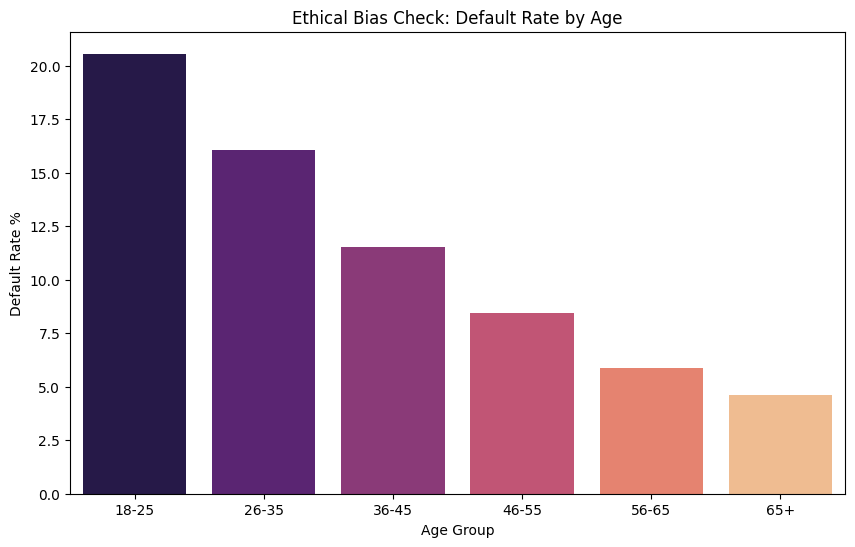

In [15]:
# Age Groups
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# calculate Default Rate per Group
bias_check = df.groupby('AgeGroup', observed=False)['Default'].mean().reset_index()
bias_check['DefaultRate_%'] = bias_check['Default'] * 100

print("Ethical Audit: Default Rate by Age Group")
print(bias_check[['AgeGroup', 'DefaultRate_%']])


plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='DefaultRate_%', data=bias_check, palette='magma')
plt.title('Ethical Bias Check: Default Rate by Age')
plt.ylabel('Default Rate %')
plt.xlabel('Age Group')
plt.show()

### Step 6: Data Encoding and Scaling

we need to convert the data into a format optimized for the algorithm.

**Transformations:**
1.  One Hot Encoding : Converting categorical text like 'Education' into binary numerical columns so the model can process them.
2.  Standard Scaling: Normalizing numerical features like Income and Age to have a mean of 0 and standard deviation of 1. This prevents variables with larger magnitudes from dominating the loss function.

In [16]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Default', 'AgeGroup'])
y = df['Default']


X_encoded = pd.get_dummies(X, drop_first=True)
print(f"Encoding: Converted text columns. Feature count grew from {X.shape[1]} to {X_encoded.shape[1]}.")


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

print("Scaling All features are now centered around 0 with similar sizing.")
print("\nFinal Processed Data Preview:")
print(X_scaled.head(3))

Encoding: Converted text columns. Feature count grew from 18 to 26.
Scaling All features are now centered around 0 with similar sizing.

Final Processed Data Preview:
        Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
0  0.833990  0.089693   -1.086833    -0.341492        0.590533   
1  1.701221 -0.823021   -0.044309    -0.731666       -1.285731   
2  0.166888  0.043854    0.022715    -0.775718       -0.968209   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio  LoanToIncomeRatio  ...  \
0        1.341937      0.261771 -0.001526 -0.260753          -0.729550  ...   
1       -1.343791     -1.308350  1.412793  0.778585           0.133129  ...   
2        0.446694      1.156831 -0.708685 -0.823728          -0.295327  ...   

   EmploymentType_Unemployed  MaritalStatus_Married  MaritalStatus_Single  \
0                  -0.577273              -0.708268             -0.706461   
1                  -0.577273               1.411895             -0.706461   
2                   